In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, rho, gamma, aggregate_risk):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    plt.figure(figsize=(10, 5))
    plt.fill_between(lc_df.index, lc_df["risky_asset"])
    plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
    plt.legend(["risky_asset", "risk_free"])
    plt.ylim(0, 100)
    plt.show()

In [5]:
asset_data = {"risky": [0.12, 0.35], "rf":[0.04, 0.03]}

## High_school & 제조업 group
_______________

In [6]:
group_characherize_data = {"rho":0.083030, "aggregate_risk":np.sqrt(0.128567+0.005564), 
                           "fixed_effect_coeff":[7.720276+1.568559+0.224784+0.067588*2], "age_coeff_list":[-0.157337, 0.043551, -0.003399], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.720276+1.568559+0.224784+0.067588*2 + (25 * -0.157337 + ((25**2 /10) *0.043551) + ((25**3/100) * -0.003399)))}

In [7]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [8]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2714.0,2898.0,2891.0,2908.0,2930.0,2936.0,2982.0,3024.0,3072.0,3126.0,...,4744.0,4872.0,4980.0,5060.0,5153.0,5251.0,5344.0,5397.0,5431.0,5481.0
financial_wealth,1000.0,2381.0,4134.0,6390.0,9279.0,12904.0,17580.0,23554.0,31231.0,40953.0,...,753680.0,869196.0,1004518.0,1155801.0,1330973.0,1531111.0,1761241.0,2021511.0,2315864.0,2670732.0


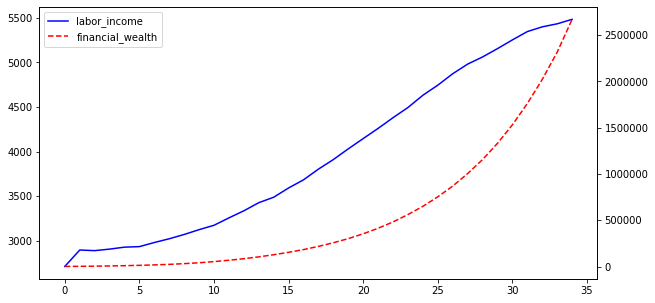

In [9]:
data_plotting(lc_data)

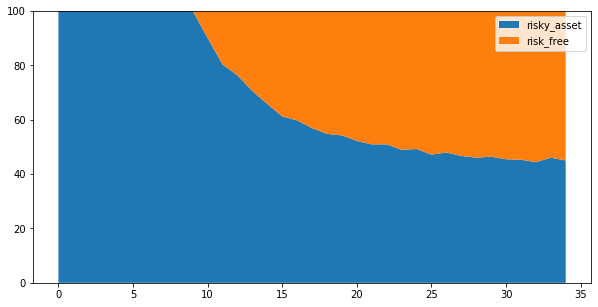

In [10]:
lc_weights_plot(lc_weights)

## University & 보건 및 사회복지업 group
_______________

In [11]:
group_characherize_data = {"rho":0.583032, "aggregate_risk":np.sqrt(0.122719-0.004858), 
                           "fixed_effect_coeff":[7.832666+7.331357+0.747807+0.027815*2], "age_coeff_list":[-0.555193, 0.136701, -0.010664], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.832666+7.331357+0.747807+0.027815*2 + (25 * -0.555193 + ((25**2 /10) *0.136701) + ((25**3/100) * -0.010664)))}

In [12]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [13]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,7826.0,8290.0,7753.0,7366.0,7053.0,6762.0,6612.0,6490.0,6419.0,6380.0,...,8946.0,9083.0,9174.0,9162.0,9170.0,9093.0,8989.0,8753.0,8466.0,8166.0
financial_wealth,1000.0,4441.0,8613.0,13813.0,20334.0,28404.0,38715.0,51805.0,68560.0,89719.0,...,4819506.0,6141867.0,7837696.0,9965518.0,12729362.0,16202204.0,20708136.0,26369981.0,33597104.0,43093591.0


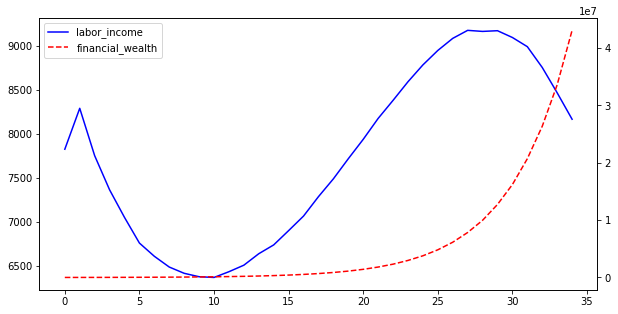

In [14]:
data_plotting(lc_data)

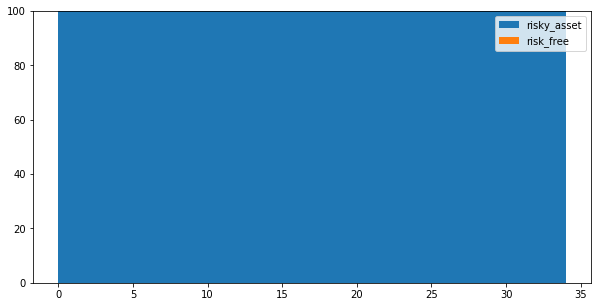

In [15]:
lc_weights_plot(lc_weights)